#What is Neural Style Transfer?
    Neural style transfer is an optimization technique used to take
    two images, a content image and a style reference image (such as
    an artwork by a famous painter), and blend them so the output
    image looks like the content image, but “painted” in the style
    of the style reference image. This technique is used by many
    popular Android iOS apps such as Prisma, DreamScope, and PicsArt.

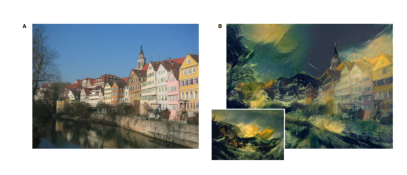

In [96]:
# Import necessary libraries
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

def showImg(url):
    # Specify the URL of the image
    # Fetch the image from the URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    # Display the image
    plt.figure(figsize=(5,5))
    plt.imshow(img)
    plt.axis('off')  # Turn off axis labels
    plt.show()

showImg('https://media.geeksforgeeks.org/wp-content/uploads/20200820225906/styletransferexample.PNG')



In [73]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import keras

# import VGG 19 model and keras Model API
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model


In [74]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file(
'content.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file(
'style.jpg',
'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


In [75]:
content_path

'/root/.keras/datasets/content.jpg'

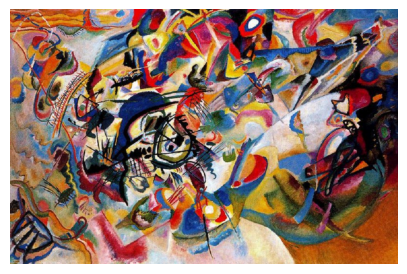

In [97]:
# Style
showImg('https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

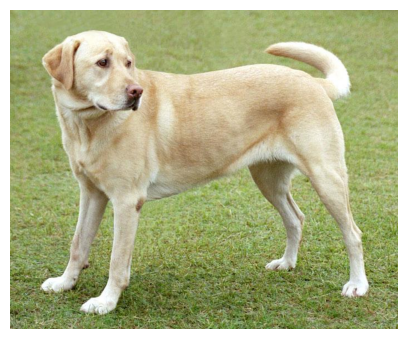

In [98]:
# Content image
showImg('https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

In [77]:
# code to load and process image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convert image to array
	img = img_to_array(img)
	img = preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [78]:
# code
def deprocess(img):
	# perform the inverse of the pre processing step
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	# convert RGB to BGR
	img = img[:, :, ::-1]

	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	# remove one dimension if image has 4 dimension
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return


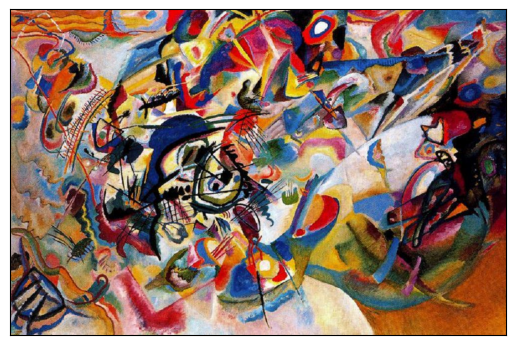

In [79]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


In [80]:
# code
# this function download the VGG model and initialise it
model = VGG19(
	include_top=False,
	weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()


Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [81]:
# define content model
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0  

In [82]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [83]:
# Content loss
def content_loss(content, generated):
	a_C = content_model(content)
	a_G = content_model(generated) # Add this line to compute a_G
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss


In [84]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


In [85]:
#style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += content_cost * weight_of_layer

	return J_style


In [86]:
#content loss
def content_cost(style, generated):
	J_content = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		content_cost = tf.reduce_mean(tf.square(GS - GG))
		J_content += content_cost * weight_of_layer

	return J_content


In [87]:
# training function
import time
generated_images = []


def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		start_time_cpu = time.process_time()
		start_time_wall = time.time()
		with tf.GradientTape() as tape:
			J_content = content_cost(style, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		end_time_cpu = time.process_time() # Record end time for CPU
		end_time_wall = time.time() # Record end time for wall time
		cpu_time = end_time_cpu - start_time_cpu # Calculate CPU time
		wall_time = end_time_wall - start_time_wall # Calculate wall time

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("CPU times: user {} µs, sys: {} ns, total: {} µs".format(
		int(cpu_time * 1e6),
		int(( end_time_cpu - start_time_cpu) * 1e9),
		int((end_time_cpu - start_time_cpu + 1e-6) * 1e6))
			)

		print("Wall time: {:.2f} µs".format(wall_time * 1e6))
		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [88]:
# Train the model and get best image
final_img = training_loop(content_path, style_path)


CPU times: user 1461540 µs, sys: 1461540574 ns, total: 1461541 µs
Wall time: 1908071.28 µs
Iteration :0
Total Loss 4.582239e+11.
CPU times: user 309904 µs, sys: 309904396 ns, total: 309905 µs
Wall time: 725315.33 µs
Iteration :1
Total Loss 3.113239e+11.
CPU times: user 329687 µs, sys: 329687054 ns, total: 329688 µs
Wall time: 734950.30 µs
Iteration :2
Total Loss 1.852595e+11.
CPU times: user 286997 µs, sys: 286997944 ns, total: 286998 µs
Wall time: 730366.47 µs
Iteration :3
Total Loss 1.519077e+11.
CPU times: user 272846 µs, sys: 272846568 ns, total: 272847 µs
Wall time: 724100.59 µs
Iteration :4
Total Loss 1.413663e+11.
CPU times: user 268046 µs, sys: 268046605 ns, total: 268047 µs
Wall time: 714798.21 µs
Iteration :5
Total Loss 1.074941e+11.
CPU times: user 506362 µs, sys: 506362518 ns, total: 506363 µs
Wall time: 945583.82 µs
Iteration :6
Total Loss 7.990533e+10.
CPU times: user 286304 µs, sys: 286304641 ns, total: 286305 µs
Wall time: 736858.37 µs
Iteration :7
Total Loss 6.531794e+

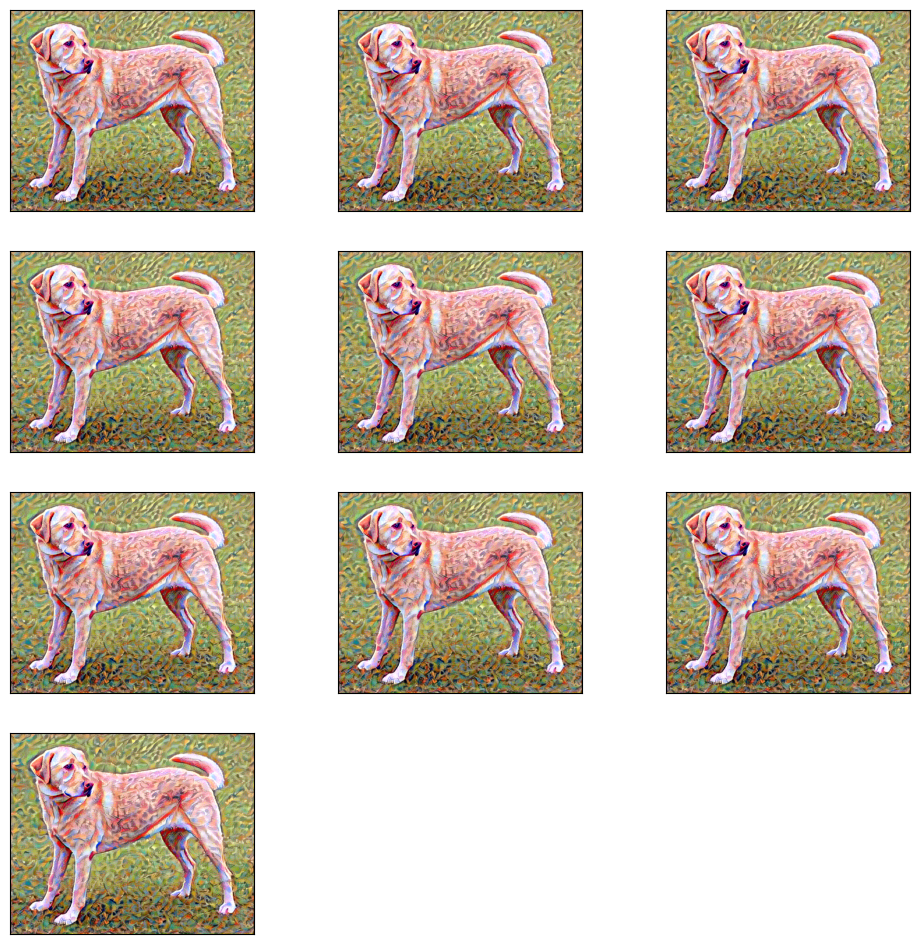

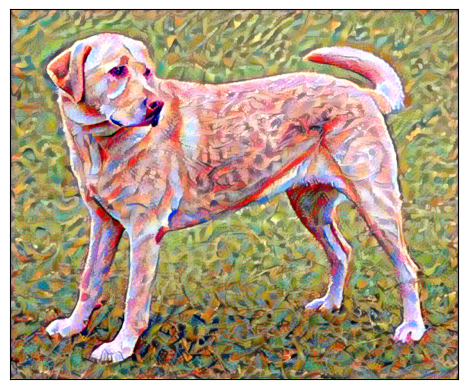

In [89]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)
